In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install torch-geometric
!pip install yfinance
!pip install ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=4c6cb8b838a31e25d9060cde8aba2b40955dbe81cb89acdc05893b5a066b125e
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [3]:
import pandas as pd
import torch

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from sklearn.cluster import KMeans
from torch_geometric.utils.convert import from_networkx

import matplotlib.dates as mdates
import yfinance as yf
from ta.momentum import rsi
from ta.trend import macd

from torch_geometric.data import Data

In [4]:
stocks = pd.read_csv("/content/drive/MyDrive/thesis/data/stocks.csv", index_col=0)
stocks.head()

,Name,Sector,Sub-Industry
Symbol,,,
MMM,3M,Industrials,Industrial Conglomerates
AOS,A. O. Smith,Industrials,Building Products
ABT,Abbott Laboratories,Health Care,Health Care Equipment
ABBV,AbbVie,Health Care,Biotechnology
ACN,Accenture,Information Technology,IT Consulting & Other Services


In [36]:
# html = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")
# stocks = html[0].set_index("Symbol")
# remove all columns
# stocks['Name'] = stocks['Security']
# stocks['Sector'] = stocks['GICS Sector']
# stocks['Sub-Industry'] = stocks['GICS Sub-Industry']

# stocks = stocks.drop(columns=['Security','GICS Sector','GICS Sub-Industry', 'Headquarters Location', 'Date added', 'CIK', 'Founded'])

# stocks = stocks.drop("GOOG")
# stocks.loc["GOOGL", "Name"] = "Alphabet"
# stocks = stocks.rename(index={"BRK.B": "BRK-B"})

# # save stocks to csv
# stocks.to_csv("/content/drive/MyDrive/thesis/data/stocks.csv")

# stocks.head()

,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
Symbol,,,,,,,
MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [5]:
fundamentals = pd.read_csv("/content/drive/MyDrive/thesis/data/fundamentals.csv", index_col=0)
fundamentals.head()

,marketCap,trailingPE,forwardPE,pegRatio,priceToBook,trailingEps,forwardEps,bookValue,payoutRatio,beta,fiveYearAvgDividendYield,52WeekChange,averageVolume,enterpriseToRevenue,profitMargins
Symbol,,,,,,,,,,,,,,,
MMM,-0.097984,0.522295,-0.180484,-0.468505,0.302970,-0.228929,-0.108374,-0.046377,0.257432,-0.100111,1.575714,1.224242,-0.071401,-0.566481,-0.803729
AOS,-0.298611,-0.363723,-0.122532,-0.087976,-0.087003,-0.175456,-0.246778,-0.046057,-0.102926,0.252453,-0.077628,-0.443685,-0.254486,-0.461583,0.077309
ABT,0.316897,0.053469,-0.019231,-0.029948,-0.111747,-0.198901,-0.208128,-0.045550,-0.032850,-0.725112,-0.140732,-0.294752,0.014815,-0.019098,0.026314
ABBV,0.720455,0.801418,-0.229350,-0.046687,1.199007,-0.212064,0.046226,-0.046553,0.257347,-0.963208,1.468436,-0.182587,-0.033434,0.361681,-0.294083
ACN,0.417556,-0.019247,0.098764,-0.033296,-0.017136,0.136745,0.119845,-0.044339,-0.076370,0.458498,-0.330046,-0.196199,-0.181528,-0.317870,-0.182898


In [39]:
# fundamentals = [
# 	yf.Ticker(stock).info for stock in stocks.index
# ]
# fundamentals = pd.DataFrame(fundamentals).set_index("symbol")
# fundamentals.index = fundamentals.index.rename("Symbol")  # for consistency with the stocks dataframe
# fundamentals = fundamentals[["marketCap", "trailingPE", "forwardPE", "pegRatio", "priceToBook", "trailingEps", "forwardEps", "bookValue", "payoutRatio", "beta", "fiveYearAvgDividendYield", "52WeekChange", "averageVolume", "enterpriseToRevenue", "profitMargins"]].fillna(0)
# fundamentals.drop(fundamentals[fundamentals.index == 'KEY'].index, inplace=True)

# fundamentals.head()

,marketCap,trailingPE,forwardPE,pegRatio,priceToBook,trailingEps,forwardEps,bookValue,payoutRatio,beta,fiveYearAvgDividendYield,52WeekChange,averageVolume,enterpriseToRevenue,profitMargins
Symbol,,,,,,,,,,,,,,,
MMM,7.407489e+10,52.466927,17.133417,-4.76,18.916946,2.57,7.87,7.128,2.0272,0.995,4.36,0.789488,4108520.0,2.379,0.02891
AOS,1.146342e+10,20.310078,19.124086,2.06,5.996795,3.87,4.11,13.107,0.3256,1.149,1.74,0.179472,1024034.0,2.906,0.14674
ABT,2.035509e+11,35.451515,22.672482,3.10,5.177007,3.30,5.16,22.598,0.6565,0.722,1.64,0.233942,5561009.0,5.129,0.13992
ABBV,3.294931e+11,62.597313,15.454846,2.80,48.603436,2.98,12.07,3.838,2.0268,0.618,4.19,0.274964,4748157.0,7.042,0.09707
ACN,2.349646e+11,32.81239,26.725658,3.04,8.311524,11.46,14.07,45.242,0.4510,1.239,1.34,0.269985,2253176.0,3.628,0.11194


In [18]:
# normalized_fundamentals = (fundamentals - fundamentals.mean()) / fundamentals.std()
# normalized_fundamentals.head()

# # save normalized fundamentals to csv
# normalized_fundamentals.to_csv("/content/drive/MyDrive/thesis/data/fundamentals.csv")

,marketCap,trailingPE,forwardPE,pegRatio,priceToBook,trailingEps,forwardEps,bookValue,payoutRatio,beta,fiveYearAvgDividendYield,52WeekChange,averageVolume,enterpriseToRevenue,profitMargins
Symbol,,,,,,,,,,,,,,,
MMM,-0.097984,0.522295,-0.180484,-0.468505,0.302970,-0.228929,-0.108374,-0.046377,0.257432,-0.100111,1.575714,1.224242,-0.071401,-0.566481,-0.803729
AOS,-0.298611,-0.363723,-0.122532,-0.087976,-0.087003,-0.175456,-0.246778,-0.046057,-0.102926,0.252453,-0.077628,-0.443685,-0.254486,-0.461583,0.077309
ABT,0.316897,0.053469,-0.019231,-0.029948,-0.111747,-0.198901,-0.208128,-0.045550,-0.032850,-0.725112,-0.140732,-0.294752,0.014815,-0.019098,0.026314
ABBV,0.720455,0.801418,-0.229350,-0.046687,1.199007,-0.212064,0.046226,-0.046553,0.257347,-0.963208,1.468436,-0.182587,-0.033434,0.361681,-0.294083
ACN,0.417556,-0.019247,0.098764,-0.033296,-0.017136,0.136745,0.119845,-0.044339,-0.076370,0.458498,-0.330046,-0.196199,-0.181528,-0.317870,-0.182898


In [16]:
values = [
	yf.Ticker(stock).history(period="5y", actions=False) for stock in stocks.index
]

for idx, stock_values in enumerate(values):
	stock_values["NormClose"] = (stock_values["Close"] - stock_values["Close"].mean()) / stock_values["Close"].std()
	# Log returns
	stock_values["DailyLogReturn"] = np.log(1 + stock_values["Close"].pct_change())
	stock_values["ALR1W"] = stock_values["DailyLogReturn"].rolling(window=5).sum() * 5
	stock_values["ALR2W"] = stock_values["DailyLogReturn"].rolling(window=10).sum() * 5
	stock_values["ALR1M"] = stock_values["DailyLogReturn"].rolling(window=21).sum() * 21
	stock_values["ALR2M"] = stock_values["DailyLogReturn"].rolling(window=42).sum() * 21
	# Normalizing the standard deviation
	stock_values["DailyLogReturn"] /= stock_values["DailyLogReturn"].std()
	stock_values["ALR1W"] /= stock_values["ALR1W"].std()
	stock_values["ALR2W"] /= stock_values["ALR2W"].std()
	stock_values["ALR1M"] /= stock_values["ALR1M"].std()
	stock_values["ALR2M"] /= stock_values["ALR2M"].std()
	stock_values["RSI"] = rsi(stock_values["Close"]) / 100
	stock_values["MACD"] = macd(stock_values["Close"])
	stock_values.drop(columns=["Open", "High", "Low", "Volume"], inplace=True)


values = pd.concat(values, keys=stocks.index)
values.drop(columns=["Adj Close"], inplace=True)

values.dropna(inplace=True)
values.head()

AttributeError: 'list' object has no attribute 'head'

In [24]:
values.to_csv("/content/drive/MyDrive/thesis/data/values.csv")

In [ ]:
values = pd.read_csv("/content/drive/MyDrive/thesis/data/values.csv", index_col=0)
values.head()

In [ ]:
#đọc dữ liệu, sort theo ngày và tên
df = pd.read_csv('/content/sample_data/all_stocks_5yr.csv')
df.sort_values(by=['date', 'Name'], inplace=True)
df.reset_index(drop=True, inplace=True)


In [ ]:
df

,date,open,high,low,close,volume,Name
0,2013-02-08,45.0700,45.3500,45.0000,45.0800,1824755,A
1,2013-02-08,15.0700,15.1200,14.6300,14.7500,8407500,AAL
2,2013-02-08,78.3400,79.7200,78.0100,78.9000,1298137,AAP
3,2013-02-08,67.7142,68.4014,66.8928,67.8542,158168416,AAPL
4,2013-02-08,36.3700,36.4200,35.8250,36.2500,13858795,ABBV
...,...,...,...,...,...,...,...
619035,2018-02-07,71.2700,72.8600,71.1200,71.7900,1748941,XYL
619036,2018-02-07,80.0700,81.9400,80.0000,80.1300,3561068,YUM
619037,2018-02-07,121.6500,123.5200,120.7400,120.7800,1145267,ZBH
619038,2018-02-07,52.2300,54.3150,52.2200,54.0200,6427280,ZION


In [ ]:
#tách từng ngày ra các df riêng
a = []
b = []
for date, df_date in df.groupby('date'):
    a.append(df_date)
df = pd.concat(a)
a[0]

,date,open,high,low,close,volume,Name
0,2013-02-08,45.0700,45.3500,45.0000,45.0800,1824755,A
1,2013-02-08,15.0700,15.1200,14.6300,14.7500,8407500,AAL
2,2013-02-08,78.3400,79.7200,78.0100,78.9000,1298137,AAP
3,2013-02-08,67.7142,68.4014,66.8928,67.8542,158168416,AAPL
4,2013-02-08,36.3700,36.4200,35.8250,36.2500,13858795,ABBV
...,...,...,...,...,...,...,...
471,2013-02-08,27.0100,27.6400,27.0100,27.0900,1206284,XYL
472,2013-02-08,63.7000,65.4900,63.6600,65.3000,7190051,YUM
473,2013-02-08,75.0200,75.9900,74.9600,75.8500,911179,ZBH
474,2013-02-08,24.0300,24.2100,23.9500,24.1400,2104483,ZION


In [ ]:
#normalize
for i in a:
  d = i[['open','high','low','close','volume']]
  nd = (d - d.mean()) / d.std()
  i[['open','high','low','close','volume']] = nd[['open','high','low','close','volume']]
  b.append(i)


In [ ]:
b[0]

,date,open,high,low,close,volume,Name
0,2013-02-08,-0.248746,-0.251580,-0.245489,-0.251922,-0.252283,A
1,2013-02-08,-0.822831,-0.823006,-0.827844,-0.826909,0.336888,AAL
2,2013-02-08,0.387914,0.398102,0.387488,0.389227,-0.299416,AAP
3,2013-02-08,0.184577,0.184151,0.174312,0.179824,13.740827,AAPL
4,2013-02-08,-0.415231,-0.420380,-0.421423,-0.419319,0.824791,ABBV
...,...,...,...,...,...,...,...
471,2013-02-08,-0.594345,-0.586345,-0.590454,-0.592971,-0.307637,XYL
472,2013-02-08,0.107761,0.129118,0.112322,0.131402,0.227923,YUM
473,2013-02-08,0.324382,0.327596,0.329004,0.331406,-0.334050,ZBH
474,2013-02-08,-0.651371,-0.651181,-0.649130,-0.648896,-0.227246,ZION


In [ ]:
#tìm những stock luôn luôn nằm trong SP500
d = []
for i in b:
  stock_list = list(i['Name'].unique())
  d.append(stock_list)
result = set.intersection(*[set(x) for x in d])
len(result)


In [ ]:
#loại những stock không nằm trong SP500 trong suốt cả quá trình
e = []
for i in b:
  i = i[i['Name'].isin([x for x in result])]
  e.append(i)
e[1]


,date,open,high,low,close,volume,Name
476,2013-02-11,-0.250158,-0.255115,-0.257259,-0.260098,-0.131842,A
477,2013-02-11,-0.824635,-0.824993,-0.835130,-0.833479,0.536487,AAL
478,2013-02-11,0.385029,0.382008,0.370189,0.382719,-0.373495,AAP
479,2013-02-11,0.184331,0.200053,0.185995,0.195741,13.994420,AAPL
480,2013-02-11,-0.421667,-0.425115,-0.423787,-0.426558,0.217249,ABBV
...,...,...,...,...,...,...,...
947,2013-02-11,-0.592796,-0.588504,-0.590889,-0.586168,-0.360390,XYL
948,2013-02-11,0.129095,0.122852,0.126139,0.119428,0.141145,YUM
949,2013-02-11,0.330010,0.326663,0.334203,0.330594,-0.383862,ZBH
950,2013-02-11,-0.649143,-0.649515,-0.648887,-0.647996,-0.252335,ZION


In [ ]:
e[1]

,date,open,high,low,close,volume,Name
476,2013-02-11,-0.250158,-0.255115,-0.257259,-0.260098,-0.131842,A
477,2013-02-11,-0.824635,-0.824993,-0.835130,-0.833479,0.536487,AAL
478,2013-02-11,0.385029,0.382008,0.370189,0.382719,-0.373495,AAP
479,2013-02-11,0.184331,0.200053,0.185995,0.195741,13.994420,AAPL
480,2013-02-11,-0.421667,-0.425115,-0.423787,-0.426558,0.217249,ABBV
...,...,...,...,...,...,...,...
947,2013-02-11,-0.592796,-0.588504,-0.590889,-0.586168,-0.360390,XYL
948,2013-02-11,0.129095,0.122852,0.126139,0.119428,0.141145,YUM
949,2013-02-11,0.330010,0.326663,0.334203,0.330594,-0.383862,ZBH
950,2013-02-11,-0.649143,-0.649515,-0.648887,-0.647996,-0.252335,ZION


In [ ]:
#tìm adj matrix bằng correlation
c = []
for i in e:
  columns = ['Name','open','high','low','close','volume']
  df1 = pd.DataFrame(i, columns=columns)
  day = i['date'].iloc[0]
  df1.set_index('Name',inplace=True)
  df1 = df1.transpose().corr(method="spearman")
  c.append([df1,day])


In [ ]:
#xây dựng edge feature (correlation map)
edge_feature = []
for i in range(len(c)):
  fundamentals_corr = c[i][0]
  fundamentals_corr.index.name = c[i][1]
  fundamentals_corr_np = fundamentals_corr.to_numpy()
  adj_fundamentals_corr = (fundamentals_corr_np * (abs(fundamentals_corr_np) > .8).astype(int))

  adj = abs(fundamentals_corr_np)
  adj = adj * (abs(adj) > .7)
  edge_feature_daily = adj / adj.max()
  edge_feature.append(edge_feature_daily)


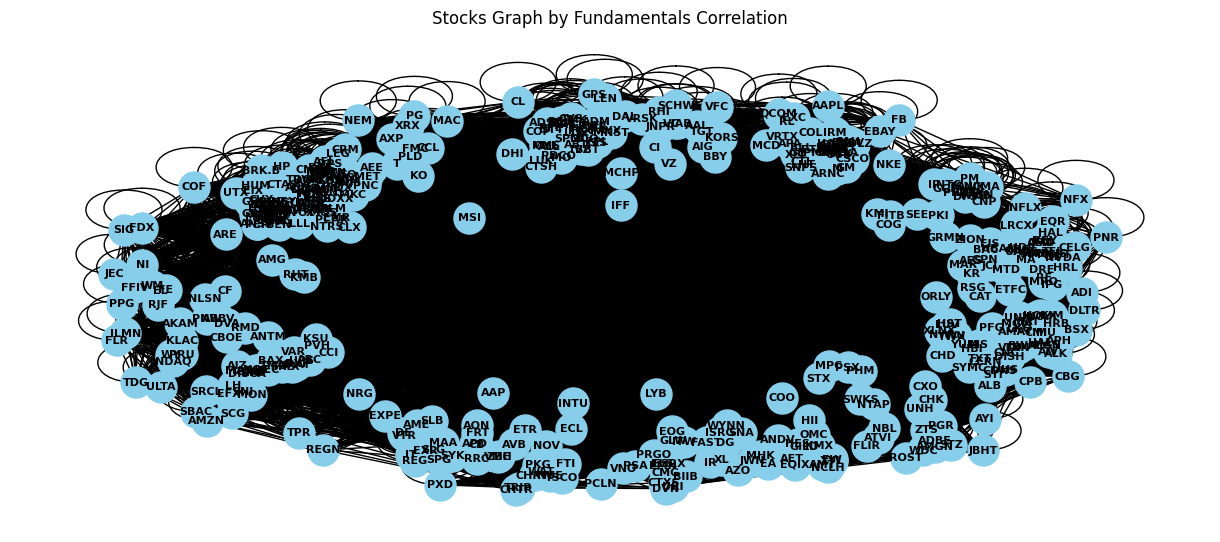

In [ ]:
#Xây graph
fundamentals_corr = c[0][0]
fundamentals_corr_np = fundamentals_corr.to_numpy()
adj_fundamentals_corr = (fundamentals_corr_np * (abs(fundamentals_corr_np) > .8).astype(int))

fundamentals_corr_graph = nx.from_numpy_array(adj_fundamentals_corr)
fundamentals_corr_graph = nx.relabel_nodes(fundamentals_corr_graph, dict(enumerate(fundamentals_corr.index)))

plt.figure(figsize=(12, 5))
nx.draw(fundamentals_corr_graph, with_labels=True, node_size=500, node_color='skyblue', font_size=8, font_weight='bold', font_color='black', pos=nx.spring_layout(fundamentals_corr_graph))
plt.title('Stocks Graph by Fundamentals Correlation')
plt.show()

In [ ]:
#Sort theo từng stock
f = pd.concat(e)
f.sort_values(by=['Name', 'date'], inplace=True)
f.reset_index(drop=True, inplace=True)
f.set_index(['Name', 'date'], inplace=True)
f


open      high       low     close    volume
Name date                                                        
A    2013-02-08 -0.248746 -0.251580 -0.245489 -0.251922 -0.252283
     2013-02-11 -0.250158 -0.255115 -0.257259 -0.260098 -0.131842
     2013-02-12 -0.256954 -0.260478 -0.257071 -0.261503 -0.191002
     2013-02-13 -0.259304 -0.257185 -0.255164 -0.260239 -0.230434
     2013-02-14 -0.257941 -0.265371 -0.258484 -0.263024 -0.151545
...                   ...       ...       ...       ...       ...
ZTS  2018-02-01 -0.246008 -0.243709 -0.241420 -0.240782 -0.238463
     2018-02-02 -0.238791 -0.239242 -0.235124 -0.237421 -0.290946
     2018-02-05 -0.235527 -0.240177 -0.239656 -0.237162 -0.298368
     2018-02-06 -0.236120 -0.242152 -0.232953 -0.247053 -0.210352
     2018-02-07 -0.249537 -0.244377 -0.245888 -0.241615 -0.119784

[591730 rows x 5 columns]

In [ ]:
#xây dựng node_feature
f = pd.concat(e)
f.sort_values(by=['date', 'Name'], inplace=True)
node_feature = []
node_feature_daily = []
a = [x for _, x in f.groupby('date')]
list_of_stock = a[0].Name.tolist()
list_of_day = f.date.unique().tolist()
counter = 0
for i in a:
  date = i.date.iloc[0]
  i.reset_index(inplace=True)
  i.set_index(['Name'], inplace=True)
  i.drop(['date'], axis=1, inplace=True)
  i.drop(['index'], axis=1, inplace=True)
  g = i.to_dict(orient='records')
  for j in g:
    node_feature_daily.append((list_of_stock[counter], j))
    counter+=1
  node_feature.append(node_feature_daily)
  node_feature_daily = []
  counter = 0


In [ ]:
list_of_day

['2013-02-08',
 '2013-02-11',
 '2013-02-12',
 '2013-02-13',
 '2013-02-14',
 '2013-02-15',
 '2013-02-19',
 '2013-02-20',
 '2013-02-21',
 '2013-02-22',
 '2013-02-25',
 '2013-02-26',
 '2013-02-27',
 '2013-02-28',
 '2013-03-01',
 '2013-03-04',
 '2013-03-05',
 '2013-03-06',
 '2013-03-07',
 '2013-03-08',
 '2013-03-11',
 '2013-03-12',
 '2013-03-13',
 '2013-03-14',
 '2013-03-15',
 '2013-03-18',
 '2013-03-19',
 '2013-03-20',
 '2013-03-21',
 '2013-03-22',
 '2013-03-25',
 '2013-03-26',
 '2013-03-27',
 '2013-03-28',
 '2013-04-01',
 '2013-04-02',
 '2013-04-03',
 '2013-04-04',
 '2013-04-05',
 '2013-04-08',
 '2013-04-09',
 '2013-04-10',
 '2013-04-11',
 '2013-04-12',
 '2013-04-15',
 '2013-04-16',
 '2013-04-17',
 '2013-04-18',
 '2013-04-19',
 '2013-04-22',
 '2013-04-23',
 '2013-04-24',
 '2013-04-25',
 '2013-04-26',
 '2013-04-29',
 '2013-04-30',
 '2013-05-01',
 '2013-05-02',
 '2013-05-03',
 '2013-05-06',
 '2013-05-07',
 '2013-05-08',
 '2013-05-09',
 '2013-05-10',
 '2013-05-13',
 '2013-05-14',
 '2013-05-

In [ ]:
node_feature[0]

[('A',
  {'open': -0.24874590528740628,
   'high': -0.25158010346202186,
   'low': -0.24548943151870378,
   'close': -0.25192223319644347,
   'volume': -0.25228258829492234}),
 ('AAL',
  {'open': -0.8228309993312836,
   'high': -0.8230056908957872,
   'low': -0.8278444627537178,
   'close': -0.8269090948060174,
   'volume': 0.33688788610199444}),
 ('AAP',
  {'open': 0.38791446400725366,
   'high': 0.39810224652469695,
   'low': 0.3874884934423702,
   'close': 0.3892269807711066,
   'volume': -0.29941608304307915}),
 ('AAPL',
  {'open': 0.18457735093087263,
   'high': 0.18415128212086573,
   'low': 0.17431241990776683,
   'close': 0.17982408344281675,
   'volume': 13.740826505300642}),
 ('ABBV',
  {'open': -0.41523058256013073,
   'high': -0.42038031834073586,
   'low': -0.4214231625552942,
   'close': -0.4193186719703484,
   'volume': 0.8247910421907599}),
 ('ABC',
  {'open': -0.22099845907528548,
   'high': -0.22237558700204277,
   'low': -0.21749343726111006,
   'close': -0.217608806

In [ ]:
#chuyển adj matrix sang adj tuple (phù hợp với nx)
def convert_adj_matrix_to_tuple(matrix):
    edges = []
    for i, row in enumerate(matrix):
        for j, value in enumerate(row):
            if value != 0:
                edges.append((list_of_stock[i], list_of_stock[j],{'weight':value}))
    return edges


In [ ]:
print(len(node_feature))

1259


In [ ]:

edge_feature_list = []
for i in edge_feature:
  a = convert_adj_matrix_to_tuple(i)
  edge_feature_list.append(a)
edge_feature_list[0]

In [ ]:
import networkx as nx
G = nx.Graph()

In [ ]:
node_feature[0]

[('A',
  {'open': -0.24874590528740628,
   'high': -0.25158010346202186,
   'low': -0.24548943151870378,
   'close': -0.25192223319644347,
   'volume': -0.25228258829492234}),
 ('AAL',
  {'open': -0.8228309993312836,
   'high': -0.8230056908957872,
   'low': -0.8278444627537178,
   'close': -0.8269090948060174,
   'volume': 0.33688788610199444}),
 ('AAP',
  {'open': 0.38791446400725366,
   'high': 0.39810224652469695,
   'low': 0.3874884934423702,
   'close': 0.3892269807711066,
   'volume': -0.29941608304307915}),
 ('AAPL',
  {'open': 0.18457735093087263,
   'high': 0.18415128212086573,
   'low': 0.17431241990776683,
   'close': 0.17982408344281675,
   'volume': 13.740826505300642}),
 ('ABBV',
  {'open': -0.41523058256013073,
   'high': -0.42038031834073586,
   'low': -0.4214231625552942,
   'close': -0.4193186719703484,
   'volume': 0.8247910421907599}),
 ('ABC',
  {'open': -0.22099845907528548,
   'high': -0.22237558700204277,
   'low': -0.21749343726111006,
   'close': -0.217608806

In [ ]:
G.add_nodes_from(node_feature[0])


In [ ]:
G.add_edges_from(edge_feature)

In [ ]:
G.nodes.data()


NodeDataView({'A': {'open': -0.24874590528740628, 'high': -0.25158010346202186, 'low': -0.24548943151870378, 'close': -0.25192223319644347, 'volume': -0.25228258829492234}, 'AAL': {'open': -0.8228309993312836, 'high': -0.8230056908957872, 'low': -0.8278444627537178, 'close': -0.8269090948060174, 'volume': 0.33688788610199444}, 'AAP': {'open': 0.38791446400725366, 'high': 0.39810224652469695, 'low': 0.3874884934423702, 'close': 0.3892269807711066, 'volume': -0.29941608304307915}, 'AAPL': {'open': 0.18457735093087263, 'high': 0.18415128212086573, 'low': 0.17431241990776683, 'close': 0.17982408344281675, 'volume': 13.740826505300642}, 'ABBV': {'open': -0.41523058256013073, 'high': -0.42038031834073586, 'low': -0.4214231625552942, 'close': -0.4193186719703484, 'volume': 0.8247910421907599}, 'ABC': {'open': -0.22099845907528548, 'high': -0.22237558700204277, 'low': -0.21749343726111006, 'close': -0.21760880690190573, 'volume': -0.305263712405104}, 'ABT': {'open': -0.4531201987670266, 'high'

In [ ]:
#chuyển định dạng graph nx sang graph torch để dùng GCN
pyg_graph = from_networkx(G)
